This notebook runs comparison between the scaling for Z and the model's depth of upwelling.

In [1]:
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import cmocean as cmo
import xarray as xr
import numpy as np
from scipy import interpolate
from salishsea_tools import gsw_calls
from salishsea_tools import nc_tools, viz_tools
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_plot
import functions_profiles
import functions_upwelling_depth

# Z Scaling

In [2]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def get_scaling_vars(initial_sal, initial_tem, bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, tmask, depth_levels, sal):
    
    dep = -1 * deptht
    #lat = np.ones(1) * np.mean(nav_lat)
    #p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [dep, lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')


    #SA = initial_sal[0,:,0,0]
    #CT = initial_tem[0,:,0,0]
    #rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA, CT, p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    
    p = np.asarray([    5.0264,    15.252  ,   25.8   ,    36.828  ,   48.568  ,   61.365  ,   75.723,
         92.379,    112.4   ,   137.29   ,  169.14   ,  210.75   ,  265.7    ,  338.2,
         432.74,     553.39   ,  702.87  ,   881.92 ,   1089.    ,  1320.8   ])

    rho = np.asarray([ 1017.7 , 1022.3,  1023.3 , 1024. ,  1024.4 , 1025.,   1025.7 , 1026.3,  1026.9,
           1027.6 , 1028.1 , 1028.6 , 1029.1 , 1029.5,  1030. ,  1030.6 , 1031.3 , 1032.2,
           1033.1 , 1034.3])


    d_rho0 = np.diff(rho)
    d_dep0 = np.diff(dep)
    f_rho = interpolate.interp1d(np.arange(len(d_rho0)), d_rho0, fill_value='extrapolate')
    f_dep = interpolate.interp1d(np.arange(len(d_dep0)), d_dep0, fill_value='extrapolate')
    d_rho = f_rho(np.arange(len(d_rho0)+1))
    d_dep = f_dep(np.arange(len(d_dep0)+1))
    N = np.sqrt((-9.81 / rho)*(d_rho / d_dep))


    y_ind = 67


    u_in = u_vel[:, rim_ind, y_ind, x_ind]
    u_in_smooth = smooth(u_in, 24)
    vel_threshold = 1e-8
    permanent_duration = 24
    dt = 1 * 60 *60


    du_in = np.diff(u_in) / dt
    du_in_smooth = np.diff(u_in_smooth) / dt
    du_in_smooth_abs = abs(du_in_smooth)
    inds_below_threshold = np.where(du_in_smooth_abs < vel_threshold)[0]
    spacing_inds = np.diff(inds_below_threshold)
    subind_permanent_steady = np.where(spacing_inds > permanent_duration)[0][0] + 1
    time_ind_adv_du = inds_below_threshold[subind_permanent_steady]
    time_ind_adv = time_ind_adv_du + 1
    U_incoming = np.mean(u_in[time_ind_adv:408])
    
    return p, rho, N, y_ind, U_incoming, time_ind_adv



def get_Z_AH10(nav_lat, curv_rad_km, U_incoming, L, N):

    lat = np.mean(nav_lat)
    omega = (2 * np.pi) / (24 * 60 * 60)
    f = 2 * omega * np.sin(np.deg2rad(lat))

    curv_rad = curv_rad_km * 1000 

    R0 = abs(U_incoming) / (f * curv_rad)

    F_R0 = R0 / (0.9 + R0)

    #x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
    #y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
    #z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(0, 0)

    RL = abs(U_incoming) / (f * L)

    DH = (f * L) / N[rim_ind]

    Z_AH10 = DH * ((1.3 * (F_R0 * RL)**0.5) + 0.06)
    
    return f, R0, F_R0, RL, DH, Z_AH10




def get_Z_HA13(U_incoming, f, L, N, RL, DH, w_mid, z_coast, z_break, y_coast, y_break):

    RW = abs(U_incoming) / (f * w_mid)

    F_RW = RW / (0.9 + RW)

    s = (z_coast - z_break) / (y_coast - y_break)

    SE = (s * N[rim_ind] / f) * ((F_RW / RL)**0.5)

    Z_HA13 =  DH * (1.8 * ((F_RW * RL)**0.5) * (1 - (0.42 * SE)) + 0.05)
    
    return RW, F_RW, s, SE, Z_HA13

# Model Z

In [3]:
def get_rim_upwelling_vars(bathy):
    diffs_x = np.zeros([bathy.shape[0], bathy.shape[1]-1])
    diffs_y = np.zeros([bathy.shape[0]-1, bathy.shape[1]])

    for n in range(bathy.shape[0]):
        diffs_x[n, :] = abs(np.diff(bathy[n, :]))

    for n in range(bathy.shape[1]):
        diffs_y[:, n] = np.diff(bathy[:, n])


    possible_rim_points = np.where((abs(diffs_x) >= 2) & (abs(diffs_x) <= 4))
    possible_rim_points_x = possible_rim_points[1]
    possible_rim_points_y = possible_rim_points[0]


    unique_ys = np.unique(possible_rim_points_y)
    rim_inds_full = np.zeros([len(unique_ys), 3])
    for n in range(len(unique_ys)):
        individual_y = unique_ys[n]
        inds_individual_y = np.where(possible_rim_points_y==individual_y)
        inds_x_for_individual_y = itemgetter(*inds_individual_y)(possible_rim_points_x)
        individual_x_min = inds_x_for_individual_y.min()
        individual_x_max = inds_x_for_individual_y.max()
        rim_inds_full[n,0] = individual_y
        rim_inds_full[n,1] = individual_x_min
        rim_inds_full[n,2] = individual_x_max


    ind_for_shelf_break = (np.abs(bathy[:,0]-80)).argmin()
    ind_end_rim = np.where(rim_inds_full[:,0] == ind_for_shelf_break)[0][0]
    rim_inds = rim_inds_full[:ind_end_rim, :]
    
    return rim_inds



def get_Z_model(sal, time_ind_adv):
    sal_full = sal
    time_shots_adv = np.arange(time_ind_adv, time_ind_adv+24)
    ED_left = np.zeros([time_shots_adv.shape[0], rim_inds.shape[0]])
    ED_right = np.zeros_like(ED_left)

    for time_shot, n in zip(time_shots_adv, np.arange(len(time_shots_adv))):

        ind_nanmax_full = functions_upwelling_depth.get_nanmax_ind_full(time_shot, sal_full)


        sal_profiles_rim_left = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,1], time_shot, sal_full)
        sal_profiles_rim_right = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,2], time_shot, sal_full)


        depth_change_left, d_new_left = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_left, sal_ref, dep_ref, depth_levels)
        depth_change_right, d_new_right = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_right, sal_ref, dep_ref, depth_levels)

        ED_left[n, :] = depth_change_left
        ED_right[n, :] = depth_change_right
        
    ED_left_mean = np.mean(ED_left, axis=0)
    ED_right_mean = np.mean(ED_right, axis=0)
    Z_model = np.max([ED_left_mean.max(), ED_right_mean.max()])
    
    return ED_left_mean, ED_right_mean, Z_model

# Load Results

In [4]:
bathy_type = 'ideal_bathy_05.nc'
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/' + bathy_type)


initial_sal = nc.Dataset('../../mackenzie_canyon/conditions/NEMO_files/salinity/salinity_doubled_20.nc')['vosaline']
initial_tem = nc.Dataset('../../mackenzie_canyon/conditions/NEMO_files/temperature/temperature_doubled_20.nc')['votemper']

gridT = xr.open_dataset('../../results_mackenzie/idealized/upwelling_events/eventB_pulse10_bdy/GYRE_1h_20170101_20170120_grid_T.nc')

nav_lat = np.asfarray(gridT['nav_lat'])
deptht = np.asfarray(gridT['deptht'])

ts_data = sio.loadmat('../../mackenzie_canyon/conditions/data/for_stratification/canyonTSdata2.mat')
i_ref = 0
sal_ref = ts_data['salcanyon2'][:, i_ref]
dep_ref = ts_data['depthcanyon2'][:, i_ref]*-1

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/' 

x_ind = 175
rim_ind = 6
curv_rad_km = 42.584509999999995

# Mackenzie Canyon - Original Winds

In [5]:
def get_results(initial_sal, initial_tem, bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, tmask, depth_levels, sal, curv_rad_km):
    p, rho, N, y_ind, U_incoming, time_ind_adv = get_scaling_vars(initial_sal, initial_tem, bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, tmask, depth_levels, sal)

    x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
    y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
    z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(0, 0)

    f, R0, F_R0, RL, DH, Z_AH10 = get_Z_AH10(nav_lat, curv_rad_km, U_incoming, L, N)

    RW, F_RW, s, SE, Z_HA13 = get_Z_HA13(U_incoming, f, L, N, RL, DH, w_mid, z_coast, z_break, y_coast, y_break)
    
    # -----------------------------------------------------------------------------
    
    ED_left_mean, ED_right_mean, Z_model = get_Z_model(sal, time_ind_adv)
    
    return N, time_ind_adv, U_incoming, R0, F_R0, RL, DH, Z_AH10, RW, F_RW, s, SE, Z_HA13, ED_left_mean, ED_right_mean, Z_model

In [6]:
cfg1 = 'upwelling_events/eventB_pulse10_bdy'
depth_levels = deptht
sal = np.asfarray(xr.open_dataset(path+cfg1+'/GYRE_1h_20170101_20170120_grid_T.nc')['vosaline'])
u_vel = np.asfarray(xr.open_dataset(path+cfg1+'/GYRE_1h_20170101_20170120_grid_U.nc')['vozocrtx'])
tmask = np.asfarray(xr.open_dataset(path+cfg1+'/mesh_mask.nc')['tmask'])
bathy = bathy_file['Bathymetry']
rim_inds = get_rim_upwelling_vars(bathy)


N1, time_ind_adv, U_incoming1, R0,\
F_R0, RL1, DH1, Z_AH1,\
RW1, F_RW1, s, SE1, Z_HA1,\
ED_left_mean1, ED_right_mean1, Z_model1 = get_results(initial_sal, initial_tem, 
                                                   bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, 
                                                   tmask, depth_levels, sal, curv_rad_km)

In [7]:
cfg2 = 'scaling_runs_cmos/higher_winds'
depth_levels = deptht
sal = np.asfarray(xr.open_dataset(path+cfg2+'/GYRE_1h_20170101_20170120_grid_T.nc')['vosaline'])
u_vel = np.asfarray(xr.open_dataset(path+cfg2+'/GYRE_1h_20170101_20170120_grid_U.nc')['vozocrtx'])
tmask = np.asfarray(xr.open_dataset(path+cfg2+'/mesh_mask.nc')['tmask'])
bathy = bathy_file['Bathymetry']
rim_inds = get_rim_upwelling_vars(bathy)


N2, time_ind_adv, U_incoming2, R0,\
F_R0, RL2, DH2, Z_AH2,\
RW2, F_RW2, s, SE2, Z_HA2,\
ED_left_mean2, ED_right_mean2, Z_model2 = get_results(initial_sal, initial_tem, 
                                                   bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, 
                                                   tmask, depth_levels, sal, curv_rad_km)

In [8]:
cfg3 = 'scaling_runs_cmos/highest_winds'
depth_levels = deptht
sal = np.asfarray(xr.open_dataset(path+cfg3+'/GYRE_1h_20170101_20170120_grid_T.nc')['vosaline'])
u_vel = np.asfarray(xr.open_dataset(path+cfg3+'/GYRE_1h_20170101_20170120_grid_U.nc')['vozocrtx'])
tmask = np.asfarray(xr.open_dataset(path+cfg3+'/mesh_mask.nc')['tmask'])
bathy = bathy_file['Bathymetry']
rim_inds = get_rim_upwelling_vars(bathy)


N3, time_ind_adv, U_incoming3, R0,\
F_R0, RL3, DH3, Z_AH3,\
RW3, F_RW3, s, SE3, Z_HA3,\
ED_left_mean3, ED_right_mean3, Z_model3 = get_results(initial_sal, initial_tem, 
                                                   bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, 
                                                   tmask, depth_levels, sal, curv_rad_km)

In [9]:
U_incoming1, U_incoming2, U_incoming3

(-0.047301840044083665, -0.049752603916158857, -0.060217446052498666)

# Observation vs Scaled Plot

In [10]:
Z_HAk = [68.3016658893,
 56.0663418764,
 101.225810506,
 81.4522757333,
 76.1725087703,
 64.5858788273,
 35.4679960021]

Z_modelk = [76.9175214995,
 56.9063211702,
 128.578306384,
 98.3323883416,
 89.2191688523,
 65.649750638,
 30.8722761752]

DHk = [98.1333333333
,83.5459459459
,137.386666667
,116.363636364
,100.072727273
,74.4727272727
,112.407272727]

colors = np.arange(len(Z_HAk))

In [72]:
labs = ['high N', 'medium N', 'low N', 'high f', 'medium f', 'low f', 
        'low U', 'low N']

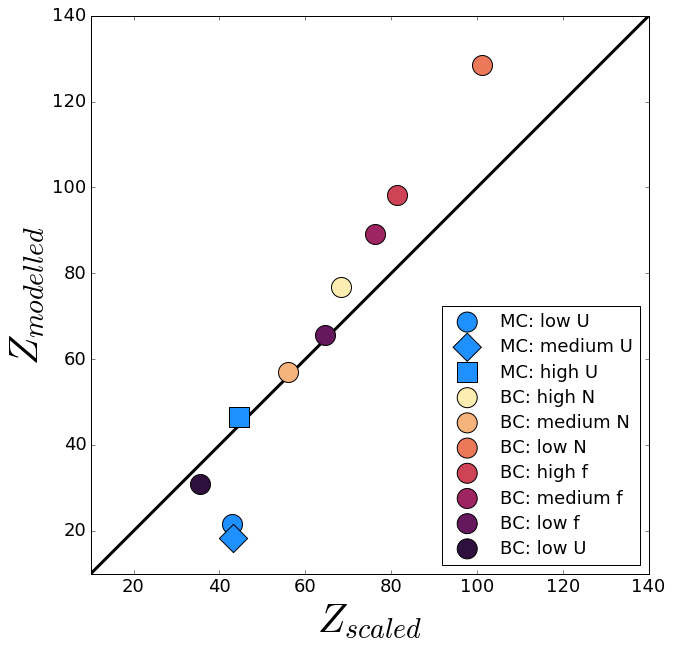

In [73]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
maxlim = 140
ax.set_xlim([10,maxlim]); ax.set_ylim([10,maxlim])

ax.plot([0, maxlim],[0, maxlim], c='k', linewidth=3, zorder=1)

s=400
n = np.arange(len(Z_HAk))
colors = cmo.cm.matter(np.linspace(0, 1, len(n)))

ax.scatter(Z_HA1, Z_model1, s=s, c='dodgerblue', zorder=3, marker='o', label ='MC: low U')
ax.scatter(Z_HA2, Z_model2, s=s, c='dodgerblue', zorder=3, marker='D', label ='MC: medium U')
ax.scatter(Z_HA3, Z_model3, s=s, c='dodgerblue', zorder=3, marker='s', label ='MC: high U')

for i in range(len(Z_HAk)):
    ax.scatter(Z_HAk[i], Z_modelk[i], s=s, c=colors[i], marker='o', zorder=3, label='BC: '+labs[i])

ax.set_xlabel('$Z_{scaled}$', fontsize=40)
ax.set_ylabel('$Z_{modelled}$', fontsize=40)

mpl.rcParams['legend.scatterpoints'] = 1
ax.legend(loc=4, fontsize=18, labelspacing=0.4)

plt.tick_params(labelsize=18)

fig.savefig('scaling1.png', format='png', dpi=300)

In [74]:
xk = [x/y for x, y in zip(Z_HAk, DHk)]
yk = [x/y for x, y in zip(Z_modelk, DHk)]

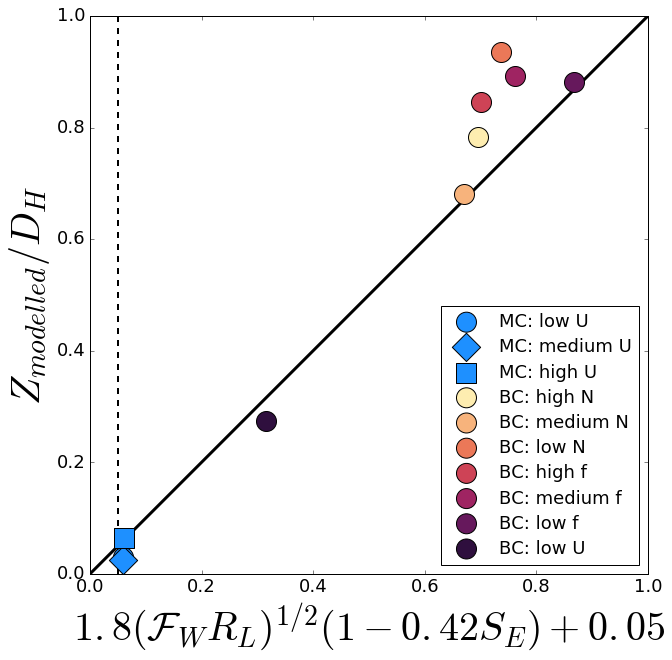

In [75]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
maxlim = 1.0
ax.set_xlim([0,maxlim]); ax.set_ylim([0,maxlim])

def calc_x(F_RW, RL, SE):
    x = (1.8 * ((F_RW * RL)**0.5) * (1 - (0.42 * SE)) + 0.05)
    return x

y1 = Z_model1/DH1
x1 = calc_x(F_RW1, RL1, SE1)

y2 = Z_model2/DH2
x2 = calc_x(F_RW2, RL2, SE2)

y3 = Z_model3/DH3
x3 = calc_x(F_RW3, RL3, SE3)

ax.plot([0, maxlim],[0, maxlim], c='k', linewidth=3, zorder=1)
ax.axvline(0.05, linestyle='--', c='k', linewidth=2, zorder=2)

s=400
n = np.arange(len(Z_HAk))
colors = cmo.cm.matter(np.linspace(0, 1, len(n)))

ax.scatter(x1, y1, s=s, c='dodgerblue', marker='o', zorder=3, label ='MC: low U')
ax.scatter(x2, y2, s=s, c='dodgerblue', marker='D', zorder=3, label ='MC: medium U')
ax.scatter(x3, y3, s=s, c='dodgerblue', marker='s', zorder=3, label ='MC: high U')

for i in range(len(Z_HAk)):
    ax.scatter(xk[i], yk[i], s=s, c=colors[i], marker='o', zorder=3, label='BC: '+labs[i])
    
ax.set_xlabel('$1.8 (\mathcal{F}_W R_L)^{1/2} (1-0.42 S_E) + 0.05$', fontsize=40)
ax.set_ylabel('$Z_{modelled}/D_H$', fontsize=40)

mpl.rcParams['legend.scatterpoints'] = 1
ax.legend(loc=4, fontsize=18, labelspacing=0.4)

plt.tick_params(labelsize=18)

fig.savefig('scaling2.png', format='png', dpi=300)

# Depth of Upwelling Plot

In [26]:
print(F_RW1*RW1, F_RW2*RW2, F_RW3*RW3)

6.06183395288e-05 6.70340910659e-05 9.80222113595e-05


In [42]:
N1[:5]#, print(N2[:5]), print(N3[:5])

array([ 0.06618939,  0.03031779,  0.02479642,  0.01816097,  0.02130127])

In [46]:
0.01816097/0.06618939

0.2743788694834625

In [47]:
f = 0.00013728458661861888
L = 100000
(np.mean(N1[:5])*80)/(f*L), (np.mean(N2[:5])*80)/(f*L), (np.mean(N3[:5])*80)/(f*L)

(0.18736651209368849, 0.18736651209368849, 0.18736651209368849)

In [33]:
(40*f*L)/(80*U_incoming1), (40*f*L)/(80*U_incoming2), (40*f*L)/(80*U_incoming3)

(-145.11548228427736, -137.96723770474961, -113.99070835628905)

In [34]:
    x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
    y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
    z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(0, 0)

In [48]:
0.5*(f*L)/U_incoming1, 0.5*(f*L)/U_incoming2, 0.5*(f*L)/U_incoming3

(-145.11548228427733, -137.96723770474958, -113.99070835628903)

In [57]:
u_vel = np.asfarray(xr.open_dataset(path+cfg1+'/GYRE_1h_20170101_20170120_grid_U.nc')['vozocrtx'])
u_vel[24*8, :7, 20:60, 90:130].max(), u_vel[24*8, :7, 20:60, 90:130].min()

(0.049637392163276672, -0.095670640468597412)

In [58]:
u_vel = np.asfarray(xr.open_dataset(path+cfg2+'/GYRE_1h_20170101_20170120_grid_U.nc')['vozocrtx'])
u_vel[24*8, :7, 20:60, 90:130].max(), u_vel[24*8, :7, 20:60, 90:130].min()

(0.097999490797519684, -0.10949528217315674)

In [59]:
u_vel = np.asfarray(xr.open_dataset(path+cfg3+'/GYRE_1h_20170101_20170120_grid_U.nc')['vozocrtx'])
u_vel[24*8, :7, 20:60, 90:130].max(), u_vel[24*8, :7, 20:60, 90:130].min()

(0.14860908687114716, -0.13388210535049438)

In [61]:
(w_break*f)/2*np.mean(N1[:5]), (w_break*f)/2*np.mean(N2[:5]), (w_break*f)/2*np.mean(N3[:5])

(0.13834280106617566, 0.13834280106617566, 0.13834280106617566)

In [67]:
w_break, 1300-z_paral, L

(62681.73577685928, 825.0, 100000)